In [196]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from scipy import stats

from scipy import stats, integrate
import seaborn as sns
from seaborn_qqplot import pplot
import matplotlib.gridspec as gridspec

In [197]:
# with plt.rc_context(dict(sns.axes_style("whitegrid"))):
#     fig = plt.figure(figsize=(6, 6), dpi=100)
#     sns.regplot(
#         x='y',
#         y='residuals',
#         data=df,
#         ci=None,
#         scatter_kws={"s": 50, "alpha": 1}
#     )
#     plt.tight_layout()

# setup the seaborn parameters
sns.set(color_codes=True)
config = sns.axes_style("whitegrid")
config['figure.figsize'] = (20,10)
config['xtick.labelsize'] = 18
config['ytick.labelsize'] = 18
config['axes.labelsize'] = 20

In [198]:
#response_var = 'HeatingElectricity'
response_var = 'CoolingElectricity'
#response_var = 'DistrictCoolingChilledWaterEnergy'
#response_var = 'DistrictHeatingHotWaterEnergy'
# response_var = 'ETSCoolingOutletTemperature'
# response_var = 'ETSHeatingOutletTemperature'
modeled_var = f'Modeled RF {response_var}'


df2 = pd.read_csv(f'output/smoff_sweep_v2_0.015/ValidationData/images/residual_ts_{response_var}_RF.csv')
# convert to Watts
df2[response_var] = df2[response_var] / 277777.77
df2[modeled_var] = df2[modeled_var] / 277777.77

df2['residuals'] = df2[response_var] - df2[modeled_var]  # y - yhat
# group weekdays/weekends
condlist = [df2.DayofWeek.between(1,5), df2.DayofWeek.isin([0,6])]
choices = ['Weekday', 'Weekend']
df2['DayType'] = np.select(condlist, choices)
# show random sample of data
# df2.sample(8).sort_index()
df2[['DayofWeek', 'DayType', response_var, modeled_var]].sample(8).sort_index()


,DayofWeek,DayType,CoolingElectricity,Modeled RF CoolingElectricity
43,1,Weekday,0.000000,0.000000
425,3,Weekday,0.000000,2.105286
1879,1,Weekday,0.000000,0.000000
2540,0,Weekend,0.000000,0.000000
4493,5,Weekday,0.000000,20.836585
4664,5,Weekday,62.744762,45.743308
6056,0,Weekend,0.000000,0.000000
7978,3,Weekday,2.030548,2.870620


In [199]:
# calculate the max and get the date of the max

maxes = df2[[response_var, modeled_var]].idxmax()
# mins = df2[[response_var, modeled_var]].idxmin()
sums = df2.sum()

actual_max_id = maxes[response_var]
# actual_min_id = mins[response_var]
actual_max = df2.at[actual_max_id, response_var]
actual_datetime = df2.at[actual_max_id, 'DateTime']

modeled_max_id = maxes[modeled_var]
modeled_max = df2.at[modeled_max_id, modeled_var]
modeled_datetime = df2.at[actual_max_id, 'DateTime']

print(response_var)
print(f"actual datetime: {actual_datetime}; modeled datetime {modeled_datetime}")
print(f"actual max: {actual_max}; modeled max {modeled_max}; %diff: {(modeled_max-actual_max)/actual_max*100}%")
print(f"actual sum: {sums[response_var]}; modeled sum {sums[modeled_var]}; %diff: {(sums[modeled_var]-sums[response_var])/sums[response_var]*100}%")



CoolingElectricity
actual datetime: 2006-08-07 09:00:00; modeled datetime 2006-08-07 09:00:00
actual max: 87.45084244862359; modeled max 71.10801199102433; %diff: -18.688019463277893%
actual sum: 64009.72273051222; modeled sum 66603.27934522263; %diff: 4.051816667960837%


In [200]:
filter_1 = df2[response_var] != 0
df2_no_zero = df2[filter_1]
df2_no_zero.count()
#df2_no_zero

Unnamed: 0                                  2523
DateTime                                    2523
Month                                       2523
Day                                         2523
DayofWeek                                   2523
                                            ... 
Modeled RF DistrictHeatingHotWaterEnergy    2523
Modeled RF ETSHeatingOutletTemperature      2523
Modeled RF ETSCoolingOutletTemperature      2523
residuals                                   2523
DayType                                     2523
Length: 67, dtype: int64

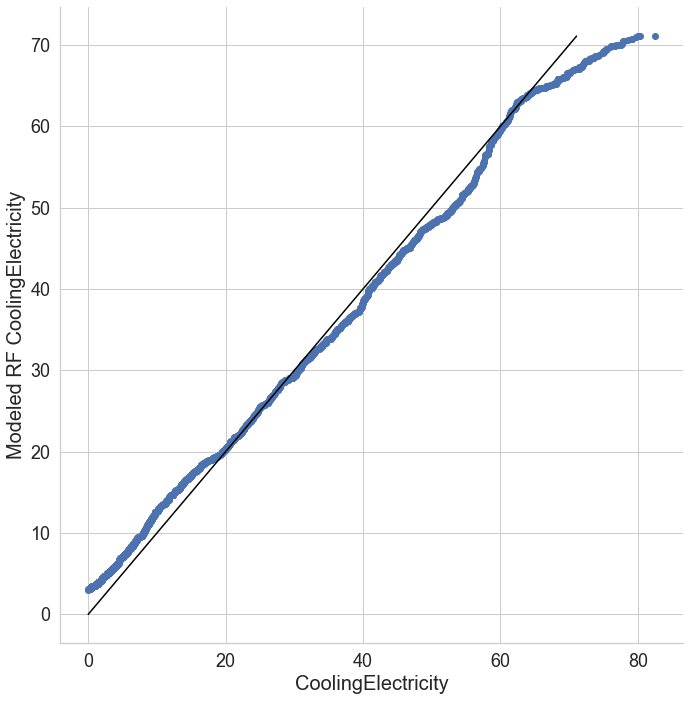

In [216]:
# plot the yy of the data
with plt.rc_context(config):
    ax = pplot(df2, x=response_var, y=modeled_var, kind='qq', height=10, aspect=1, display_kws={"identity":True})
    ax.savefig(f"fig_x_{response_var}_yy.png")

CoolingElectricity


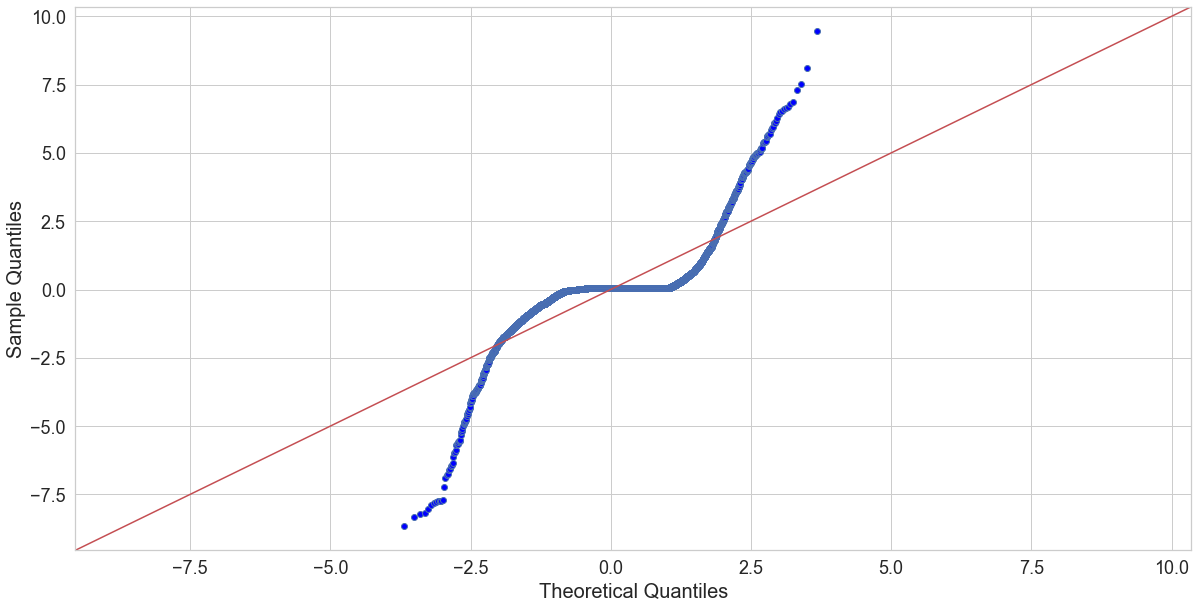

In [202]:
# qq of the data
import statsmodels.api as sm
print(response_var)
with plt.rc_context(config):
#     sm.qqplot(df2[modeled_var], line="45")
#     sm.qqplot(df2[modeled_var], fit=True, line="45")
    sm.qqplot(df2['residuals'], fit=True, line="45")
    plt.savefig(f'fig_x_{response_var}_qq.png')

/Users/nlong/.pyenv/versions/3.7.7-metamodel/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


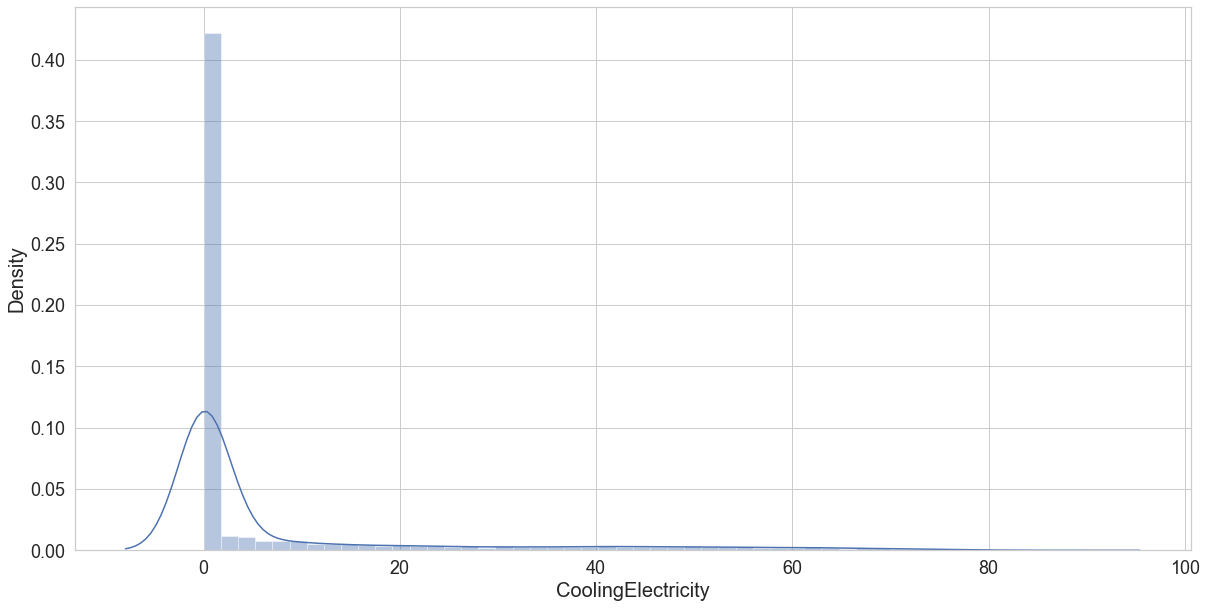

In [203]:
with plt.rc_context(config):
    # g = sns.catplot(x="DayofWeek", y="residuals", col="Month", data=df2)
    #g = sns.boxplot(x="DayofWeek", y="residuals", data=df2).get_figure()
    g = sns.distplot(df2[response_var])


    plt.legend([],[], frameon=False)
    plt.savefig(f'fig_x_{response_var}_residuals_7days.png')

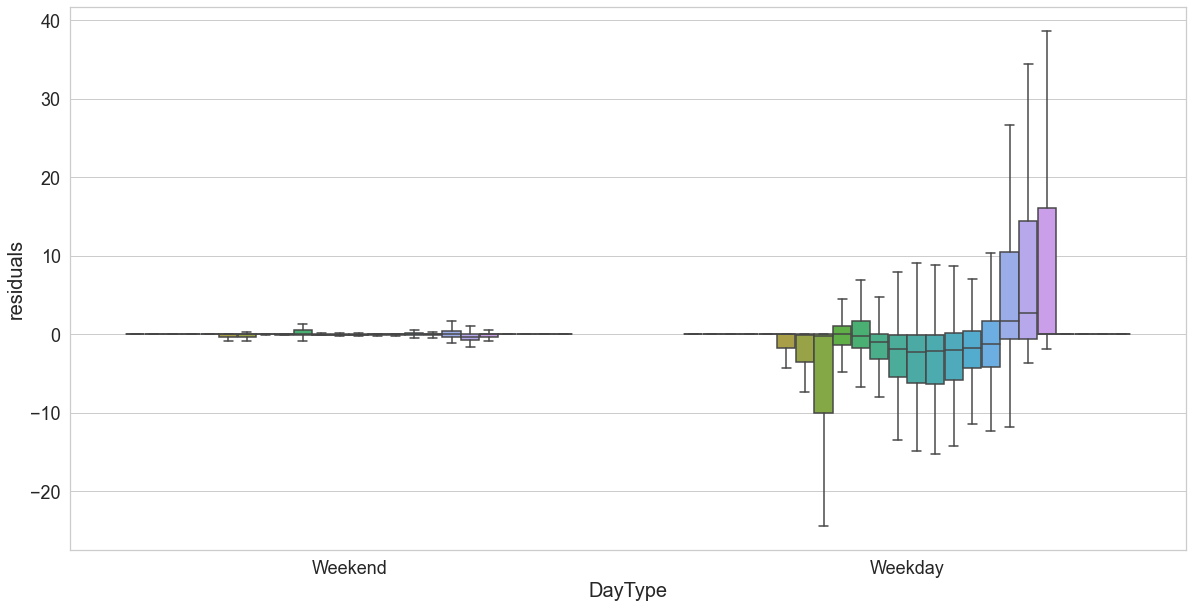

In [204]:
with plt.rc_context(config):
    g = sns.boxplot(x="DayType", y="residuals", hue="Hour", data=df2, showfliers = False)
    plt.legend([],[], frameon=False)
    plt.savefig(f'fig_17a_{response_var}_residuals_2daytypes.png')

/Users/nlong/.pyenv/versions/3.7.7-metamodel/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/nlong/.pyenv/versions/3.7.7-metamodel/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in greater_equal
  frac=frac, it=it, delta=delta, given_xvals=False)


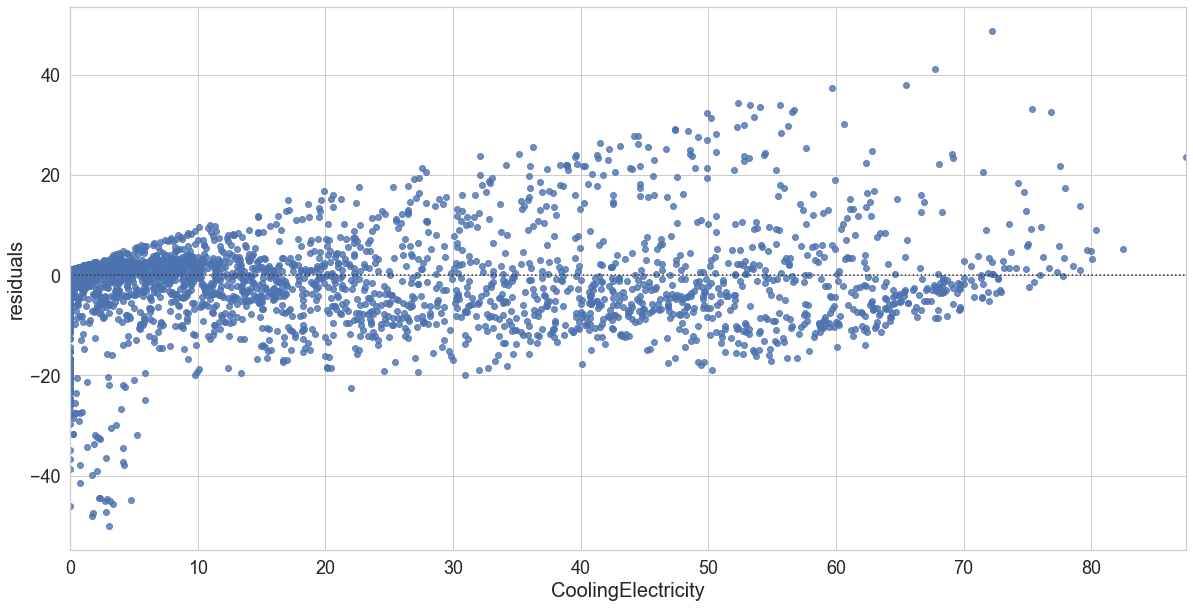

In [205]:
with plt.rc_context(config):
    sns.residplot(x=response_var, y='residuals', data=df2, lowess=True)
    plt.savefig(f'fig_x_{response_var}_resid_response.png')

In [206]:
# melt df
df2_melted = pd.melt(df2[['DateTime', response_var, modeled_var]],
                   id_vars='DateTime',
                   var_name='Variable',
                   value_name='Value')
df2_melted

,DateTime,Variable,Value
0,2006-01-01 01:00:00,CoolingElectricity,0.0
1,2006-01-01 02:00:00,CoolingElectricity,0.0
2,2006-01-01 03:00:00,CoolingElectricity,0.0
3,2006-01-01 04:00:00,CoolingElectricity,0.0
4,2006-01-01 05:00:00,CoolingElectricity,0.0
...,...,...,...
17515,2006-12-31 20:00:00,Modeled RF CoolingElectricity,0.0
17516,2006-12-31 21:00:00,Modeled RF CoolingElectricity,0.0
17517,2006-12-31 22:00:00,Modeled RF CoolingElectricity,0.0
17518,2006-12-31 23:00:00,Modeled RF CoolingElectricity,0.0


/Users/nlong/.pyenv/versions/3.7.7-metamodel/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


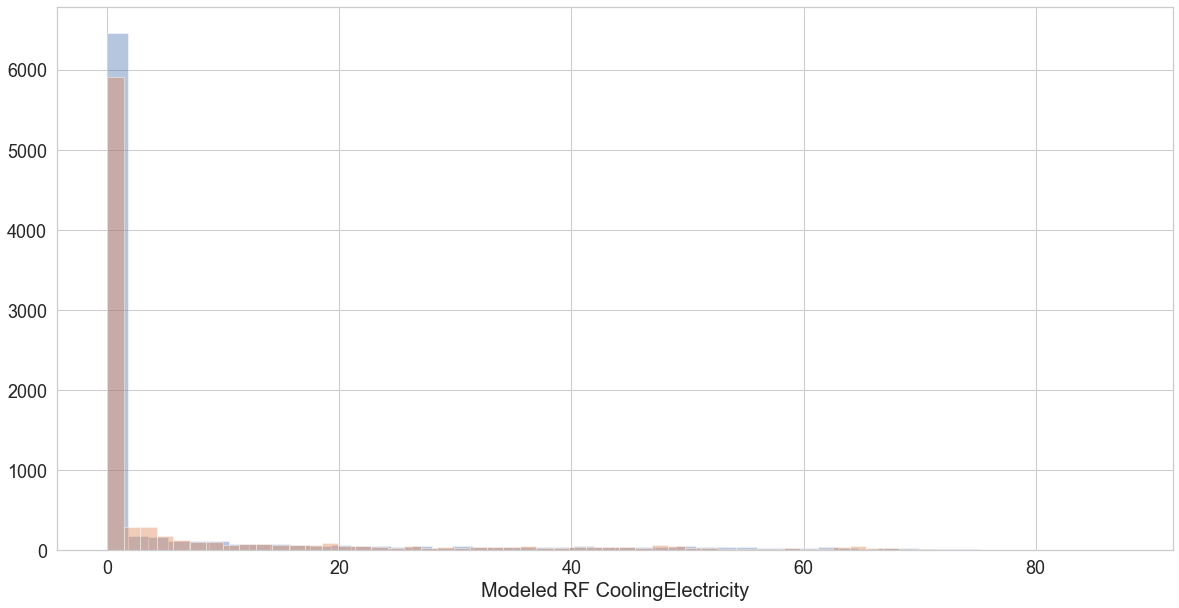

In [207]:
with plt.rc_context(config):
    ax = sns.distplot(df2[response_var], hist=True, bins=50, kde=False)
    ax = sns.distplot(df2[modeled_var], hist=True, bins=50, kde=False)
#    ax.set_ylim([0.11, 0.12])

    plt.legend([],[], frameon=False)


87.45084244862359


/Users/nlong/.pyenv/versions/3.7.7-metamodel/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


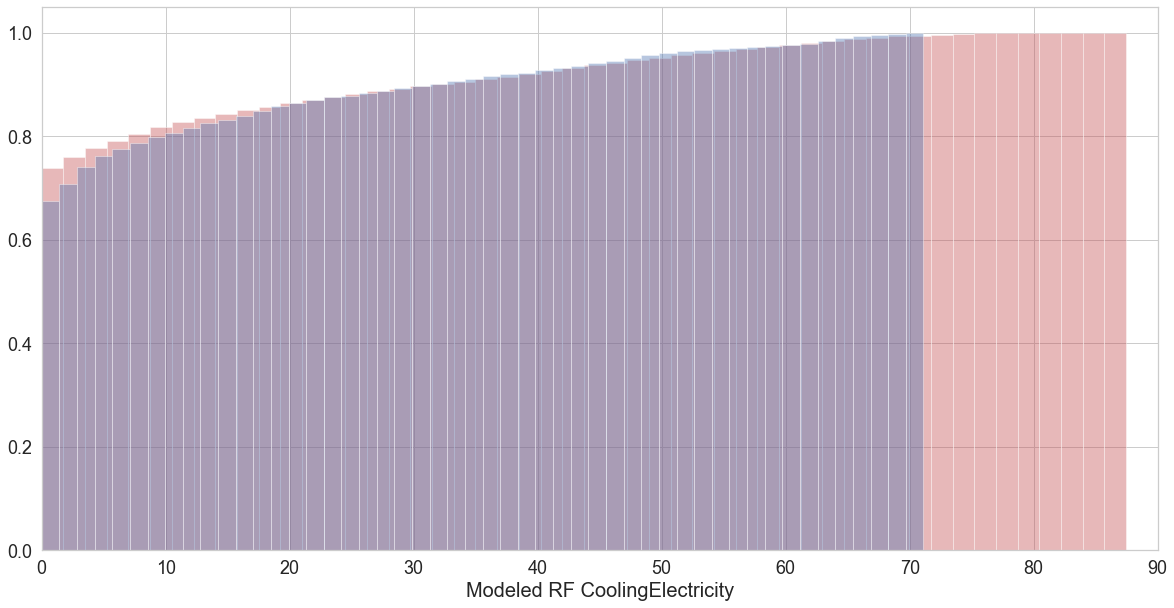

In [208]:
with plt.rc_context(config):
    kwargs = {'cumulative': True}
    bin_1 = max(df2[response_var]) - min(df2[response_var])
    print(bin_1)

    sns.distplot(df2[response_var], hist_kws=kwargs, kde_kws=kwargs, color = 'r', kde=False, norm_hist=True)
    ax = sns.distplot(df2[modeled_var], hist_kws=kwargs, kde_kws=kwargs, color = 'b', kde=False, norm_hist=True)
    ax.set_xlim(0,90)

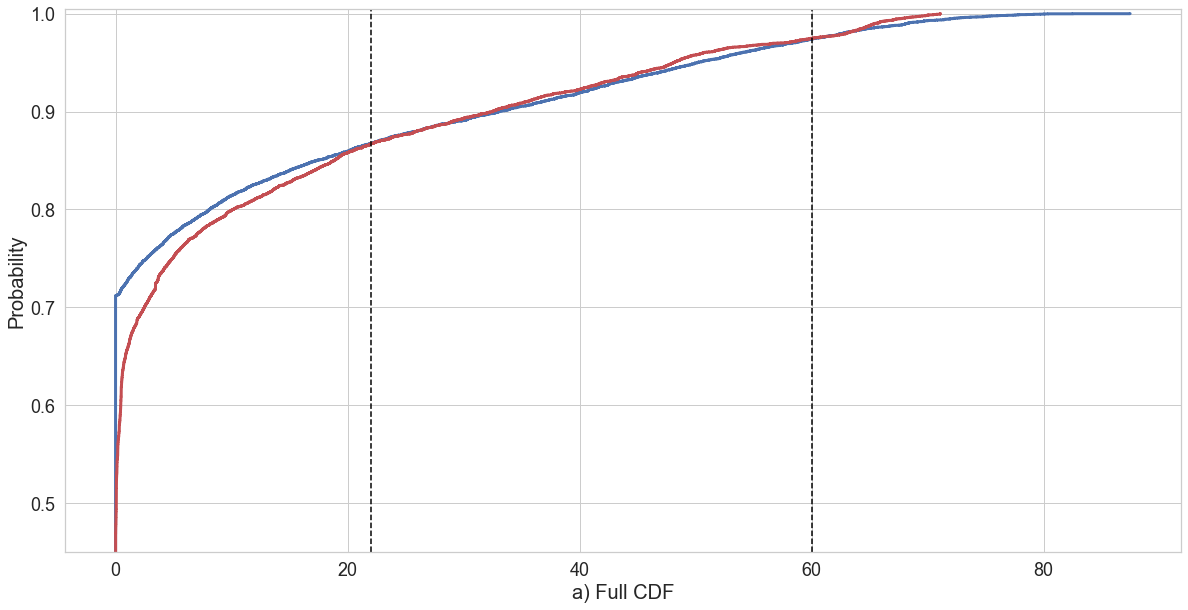

In [209]:
left_break = 22
right_break = 60
with plt.rc_context(config):
    ax1 = sns.ecdfplot(df2[response_var], color='b', lw=3)
    ax1 = sns.ecdfplot(df2[modeled_var], color='r', lw=3)
    ax1.set_ylim([0.45, 1.005])
#     ax.set_xlim([20, 60])
    ax1.set(xlabel='a) Full CDF', ylabel='Probability')
    ax1.axvline(left_break, linewidth=1.5, color='black', ls='--')
    ax1.axvline(right_break, linewidth=1.5, color='black', ls='--')

    
    
    # misses the top 1.5%
    plt.savefig(f'fig_17b_{response_var}_ecdf_full.png')


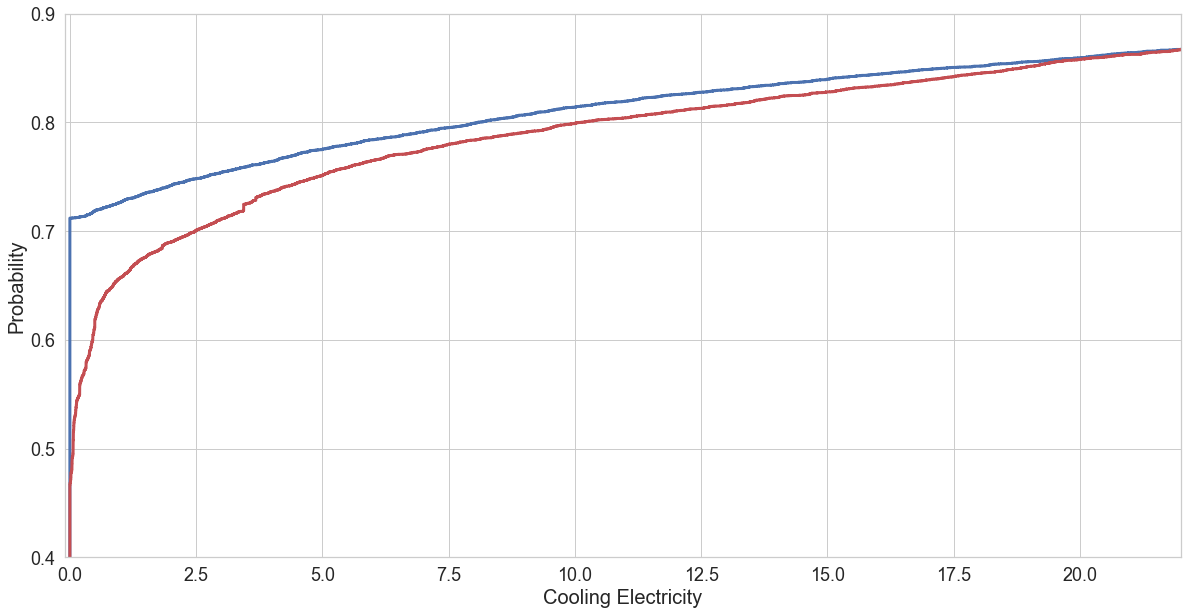

In [210]:
with plt.rc_context(config):
    ax_2 = sns.ecdfplot(df2[response_var], color='b', lw=3)
    ax_2 = sns.ecdfplot(df2[modeled_var], color='r', lw=3)
    ax_2.set_xlim(-0.1,left_break)
    ax_2.set_ylim(.4, 0.9)
    ax_2.set(xlabel='Cooling Electricity', ylabel='Probability')
    plt.savefig(f'fig_17c_{response_var}_ecdf_left.png')


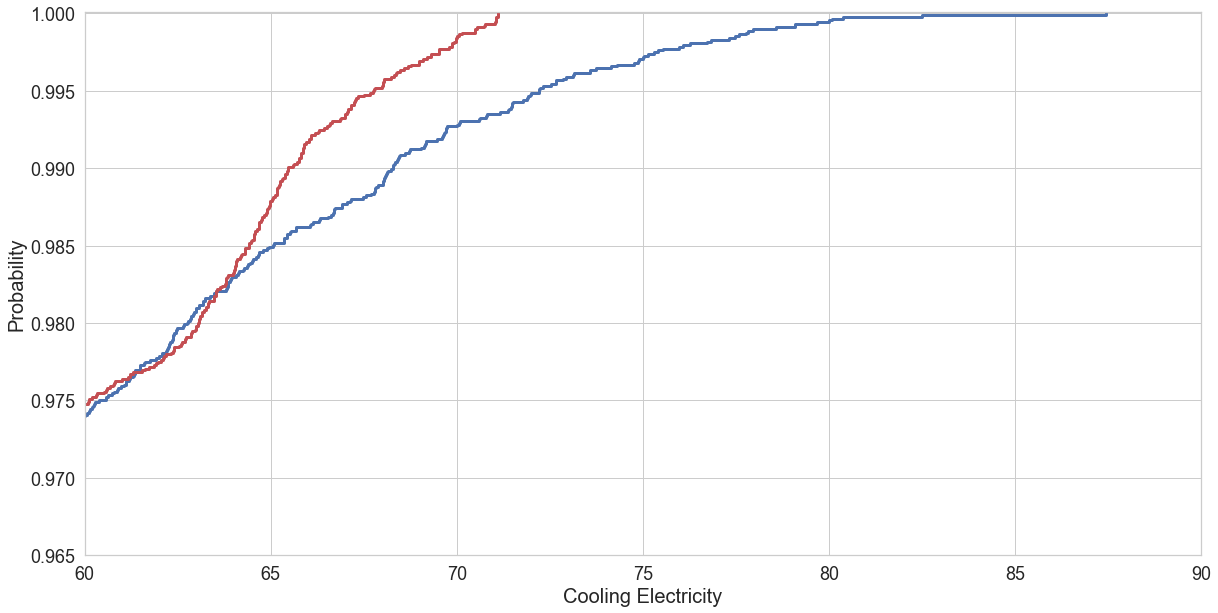

In [211]:
with plt.rc_context(config):
    ax_3 = sns.ecdfplot(df2[response_var], color='b', lw=3)
    ax_3 = sns.ecdfplot(df2[modeled_var], color='r', lw=3)
    ax_3.set_ylim([0.965, 1.0001])
    ax_3.set_xlim([right_break, 90])
    ax_3.set(xlabel='Cooling Electricity', ylabel='Probability')
    plt.savefig(f'fig_17d_{response_var}_ecdf_right.png')
    # misses the top 1.5%

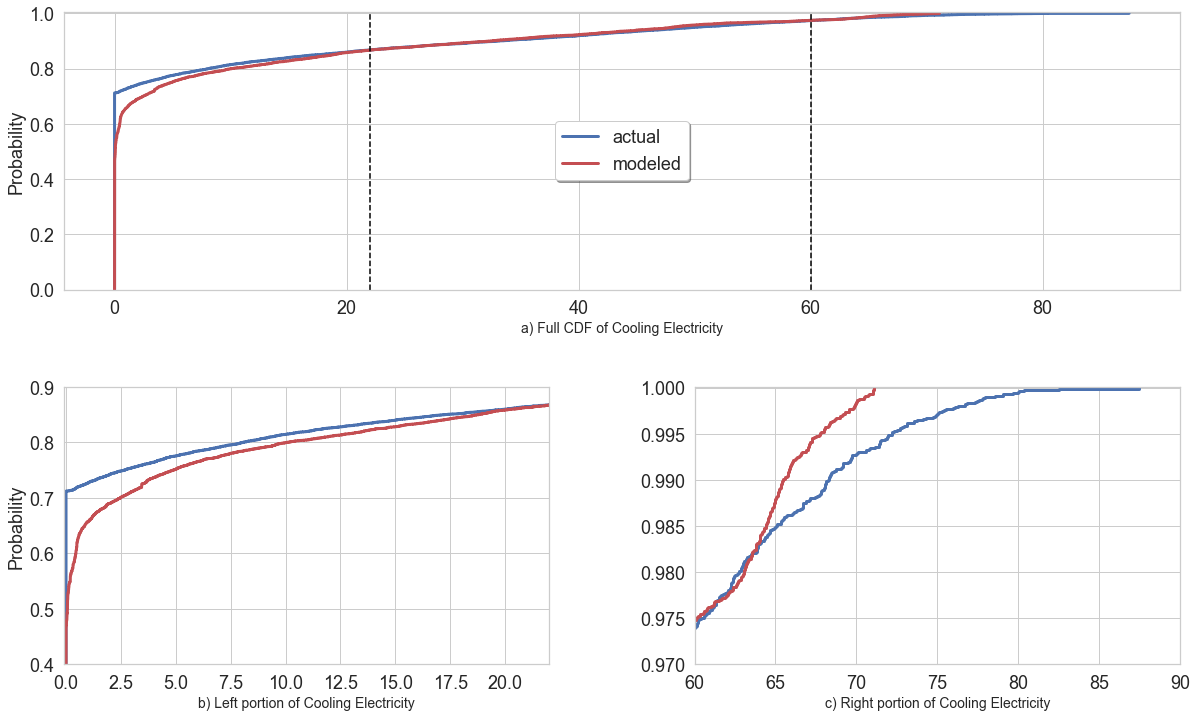

In [231]:
with plt.rc_context(config):
    gridsize = (2, 2)
    fig = plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (1, 1))

    sns.ecdfplot(df2[response_var], color='b', lw=3, ax=ax1, label='actual')
    sns.ecdfplot(df2[modeled_var], color='r', lw=3, ax=ax1, label='modeled')
    ax1.set_ylim([0.0, 1.005])
#     ax.set_xlim([20, 60])
    ax1.set_xlabel('a) Full CDF of Cooling Electricity', fontsize=14)
    ax1.set_ylabel('Probability', fontsize=18)
    ax1.axvline(left_break, linewidth=1.5, color='black', ls='--')
    ax1.axvline(right_break, linewidth=1.5, color='black', ls='--')
    ax1.legend(loc='center', shadow=True, fontsize=18)


    ax2 = sns.ecdfplot(df2[response_var], color='b', lw=3, ax=ax2)
    ax2 = sns.ecdfplot(df2[modeled_var], color='r', lw=3, ax=ax2)
    ax2.set_xlim(-0.1,left_break)
    ax2.set_ylim(.4, 0.9)
    ax2.set_xlabel('b) Left portion of Cooling Electricity', fontsize=14)
    ax2.set_ylabel('Probability', fontsize=18)
    
    ax3 = sns.ecdfplot(df2[response_var], color='b', lw=3, ax=ax3)
    ax3 = sns.ecdfplot(df2[modeled_var], color='r', lw=3, ax=ax3)
    ax3.set_ylim([0.97, 1.0001])
    ax3.set_xlim([right_break, 90])
    ax3.set_xlabel('c) Right portion of Cooling Electricity', fontsize=14)
    ax3.set_ylabel(None)
    

    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    
    # misses the top 1.5%
    plt.savefig(f'fig_17b_{response_var}_ecdf_combined.png')

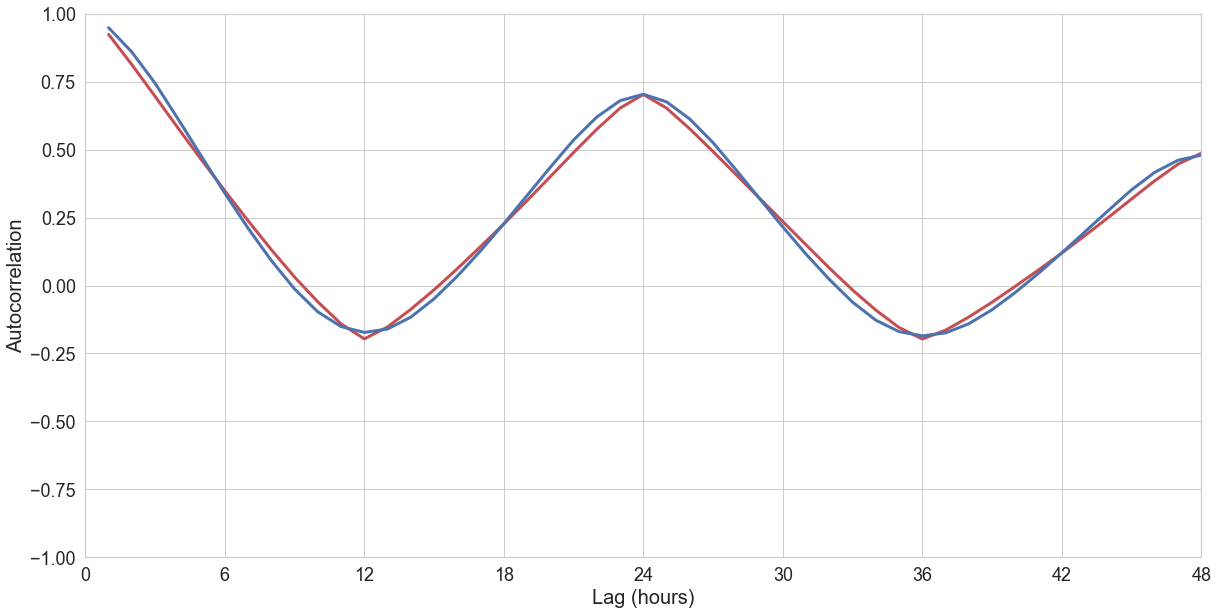

In [215]:
def autocorrelation(series, lower=0.95, upper=0.99, ax=None, **kwds):
    # require scipy
    import scipy
    import matplotlib.pyplot as plt

    n = len(series)
    data = np.asarray(series)
    if ax is None:
        ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    x = np.arange(n) + 1
    y = [r(loc) for loc in x]

    if lower and upper:
        # customize the z's
        z95, z99 = scipy.stats.t.ppf((1 + np.array([lower,upper])) / 2., 1e9)

        ax.axhline(y=z99 / np.sqrt(n), linestyle="--", color="grey")
        ax.axhline(y=z95 / np.sqrt(n), color="grey")
        ax.axhline(y=0.0, color="black")
        ax.axhline(y=-z95 / np.sqrt(n), color="grey")
        ax.axhline(y=-z99 / np.sqrt(n), linestyle="--", color="grey")

    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.plot(x, y, **kwds)
    if "label" in kwds:
        ax.legend()
    ax.grid()
    return ax


from matplotlib.ticker import MultipleLocator

with plt.rc_context(config):
    ax = autocorrelation(df2[response_var], lower=None, upper=None, color='r', lw=3)
    ax = autocorrelation(df2[modeled_var], lower=None, upper=None, color='b', lw=3)
    ax.set_xlim([0, 48])
    ax.set(xlabel='Lag (hours)')

    ax.xaxis.set_major_locator(MultipleLocator(6))
#     ax.legend(ax.get_lines())
    plt.savefig(f'fig_17e_{response_var}_acf.png')

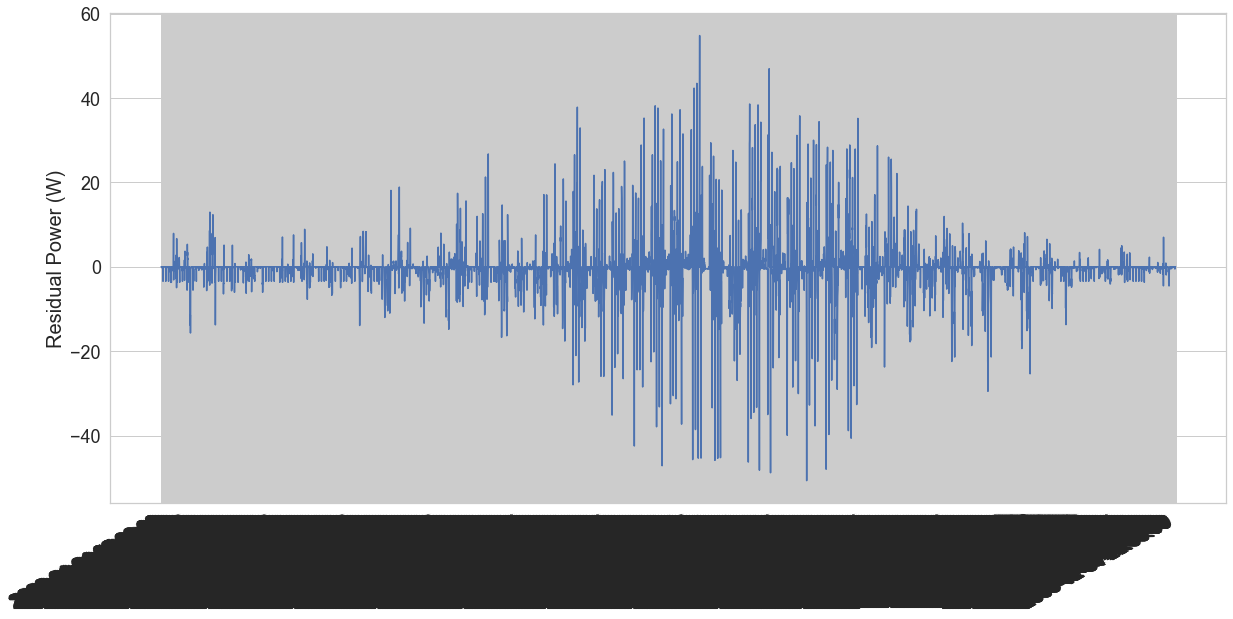

In [124]:
with plt.rc_context(config):
    ax = sns.lineplot(x='DateTime', y='residuals', data=df2, ci=None )
#     ax = sns.lineplot(data=df2_melted, x='DateTime', y='Value', hue='Variable')

#     ax.set(xlabel='', ylabel='Temperature (deg C)')
    ax.set(xlabel='', ylabel='Residual Power (W)')

    fig = ax.get_figure()
    # Put the labels at an angle since they tend to be too long
    fig.autofmt_xdate()
#     fig
